# Feature Extraction

Flow aggregation by a time window

Generated features:
* NumSrcPorts
* NumDestAddr
* NumDestPorts
* NumFlows
* NumBytes
* NumPackets

## Imports

In [28]:
import numpy as np
import pandas as pd
from datetime import datetime
import os
import glob
import time
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

import warnings

import pickle

warnings.filterwarnings("ignore")

## Functions

In [43]:
def extract_features(input_df):
    input_df['IsBotnet'] = input_df['Label'].apply(lambda x: 1 if "flow=From-Botnet" in x else 0)
    
    input_df.loc[:, "StartTime"] = pd.to_datetime(input_df.StartTime, format='%Y/%m/%d %H:%M:%S.%f')
    input_df.sort_values(by=['StartTime'], inplace=True)
    input_df.reset_index(drop=True, inplace=True)
#     input_df.head()
    
    
    # Determine the time windows
    time_windows = [0]
    for i in range(1, len(input_df)):
        # Find the optimal time window duration
        if (input_df["StartTime"][i] - input_df["StartTime"][time_windows[-1]]).seconds > 60:
            time_windows.append(i)

    time_windows.append(len(input_df)) # Added it for easier indexing             
    
    
    # Determined column keys
    column_keys = ["NumSrcPorts", "NumDestAddr", "NumDestPorts", "NumFlows", "NumBytes", "NumPackets", "IsBotnet"]
    gen_df = pd.DataFrame(None, columns=column_keys)

    print(len(time_windows))
    
    rnd_id = list(range(len(time_windows)-1))
    np.random.shuffle(rnd_id)

    # Generate the features for each time window
    for i in range(len(time_windows)-1):
        #print(str(i) + ' ', end='')
        current_df = input_df.iloc[time_windows[i]:time_windows[i+1],:]
        
        if not(1 in current_df['IsBotnet'].values or i in rnd_id[:len(time_windows)//10]):
            continue

        group = current_df.groupby("SrcAddr")

        for address, addr_df in group:
            is_botnet = addr_df['IsBotnet'].mode()[0]
            
            if (i not in rnd_id[:len(time_windows)//10] and is_botnet == 0):
                continue
                
            # TODO: Optionally source ip address can be added
#             print(address)

            num_src_ports = len(addr_df.Sport.unique())

            num_dest_addr = len(addr_df.DstAddr.unique())

            num_dest_ports = len(addr_df.Dport.unique())

            num_flows = len(addr_df)

            # TODO: SrcBytes or TotBytes?
            num_bytes = np.sum(addr_df.SrcBytes)

            num_packets = np.sum(addr_df.TotPkts)
            
            
            

            curr_gen_df = pd.DataFrame([[num_src_ports, num_dest_addr, num_dest_ports, num_flows, num_bytes, num_packets, is_botnet]], columns=column_keys)
            gen_df = gen_df.append(curr_gen_df, ignore_index=True)
            
    return gen_df


def extract_features_all(data_path):
    scenario_list = os.listdir(data_path)
    print(scenario_list)

    feat_list = []
    
    for scenario in scenario_list:
        scenario_path = os.path.join(data_path, scenario)
        
        if os.path.isdir(scenario_path):
            print(scenario)
            flow_file_path = glob.glob(os.path.join(scenario_path, "*.binetflow"))[0]
            
            # Extract features for the current scenario
            input_df = pd.read_csv(flow_file_path)
            scenario_features = extract_features(input_df)
            
            p_filename = "anomaly_cache/anomaly_scenario_features_"+str(scenario)+".p"
            pickle.dump( scenario_features, open( p_filename, "wb" ) )
            
            feat_list.append(scenario_features)
    
    return feat_list

def load_pickle_data(scenario = -1):
    if scenario == -1:
        p_filename = "anomaly_cache/anomaly_feat_list.p"
    else:
        p_filename = "anomaly_cache/anomaly_scenario_features_"+str(scenario)+".p"
        
    return pickle.load(open(p_filename, "rb" ) )

## Load and process data

In [9]:
DATA_PATH = os.path.join("..", "Project\ctu-13")

start_time = time.time()
feat_list = extract_features_all(DATA_PATH)
pickle.dump( feat_list, open( "anomaly_cache/anomaly_feat_list.p", "wb" ) )

print()
print("--- %s seconds ---" % (time.time() - start_time))
gen_feat_df9.head()

['1', '10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']
9
311
1 5 7 8 30 31 32 33 34 35 37 39 41 42 44 46 54 56 65 77 84 95 100 101 103 107 119 120 123 133 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 
--- 384.1044192314148 seconds ---


,NumSrcPorts,NumDestAddr,NumDestPorts,NumFlows,NumBytes,NumPackets,IsBotnet
0,1,1,1,1,107,2,0
1,1,1,1,1,469,2,0
2,1,1,1,1,152,4,0
3,1,1,1,1,60,4,0
4,1,1,1,1,454,2,0


# Machine Learning Models

## Generate test and train sets

In [44]:
# Learn some scenarios then test on other scenarios

X_train, y_train = gen_feat_df9.iloc[:, range(0, 6)].values, gen_feat_df9.iloc[:, 6].values
X_test, y_test = gen_feat_df6.iloc[:, range(0, 6)].values, gen_feat_df6.iloc[:, 6].values

y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Feature Counts
print("Feature Counts\n")
print("num\ttrain\ttest\ttotal")
print("-" * 30)
for i in range(0, 2):
    print("{0}\t{1}\t{2}\t{3}".format(i, np.count_nonzero(y_train==i), np.count_nonzero(y_test==i), np.count_nonzero(y_train==i)+np.count_nonzero(y_test==i)))
print("-" * 30)
print("total:\t{0}\t{1}\t{2}".format(len(y_train), len(y_test), len(y_train)+len(y_test)))

Feature Counts

num	train	test	total
------------------------------
0	26658	1303	27961
1	1382	120	1502
------------------------------
total:	28040	1423	29463


In [15]:
# Classic
# Generate test and train sets
X = gen_feat_df6.iloc[:, range(0, 6)].values
y = gen_feat_df6.iloc[:, 6].values
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

# Feature Counts
print("Feature Counts\n")
print("num\ttrain\ttest\ttotal")
print("-" * 30)
for i in range(0, 2):
    print("{0}\t{1}\t{2}\t{3}".format(i, np.count_nonzero(y_train==i), np.count_nonzero(y_test==i), np.count_nonzero(y==i)))
print("-" * 30)
print("total:\t{0}\t{1}\t{2}".format(len(y_train), len(y_test), len(y)))

Feature Counts

num	train	test	total
------------------------------
0	911	392	1303
1	85	35	120
------------------------------
total:	996	427	1423


### Scale data

In [20]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Evaluation Functions

In [21]:
def print_results():
    print("\nAccuracy:")
    print(metrics.accuracy_score(y_test, y_pred))
    
    print("\nClassification report:")
    print(metrics.classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    print(metrics.confusion_matrix(y_test, y_pred))

## Logistic Regression

In [22]:
log_regression = LogisticRegression()

# Train the classifier
log_regression.fit(X_train, y_train)

# Predict
y_pred = log_regression.predict(X_test)

print_results()


Accuracy:
0.9241040056219255

Classification report:
             precision    recall  f1-score   support

          0       0.92      1.00      0.96      1303
          1       0.88      0.12      0.21       120

avg / total       0.92      0.92      0.90      1423


Confusion Matrix:
[[1301    2]
 [ 106   14]]


## KNN
Tries for different k values and prints the metrics for the k value with the best accuracy

Results for k=19

Accuracy:
0.9936753338018272

Classification report:
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      1303
          1       0.98      0.94      0.96       120

avg / total       0.99      0.99      0.99      1423


Confusion Matrix:
[[1301    2]
 [   7  113]]


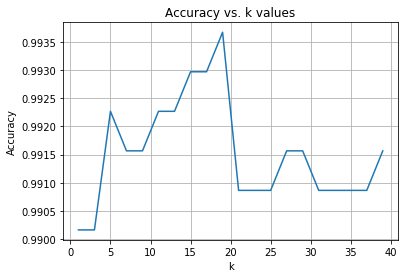

In [24]:
acc_vals = []
k_vals = []
pred_vals = []

for i in range(20):
    k = 2*i+1
    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    
    acc_vals.append(metrics.accuracy_score(y_test, y_pred))
    k_vals.append(k)
    pred_vals.append(y_pred)

# print_results()
plt.plot(k_vals, acc_vals)
plt.title("Accuracy vs. k values")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.grid(True)

# Plot the results for best k value
i_max_acc = acc_vals.index(max(acc_vals))
print("Results for k={0}".format(2*i_max_acc+1))

y_pred = pred_vals[i_max_acc]
print_results()

## 10-fold KNN

In [325]:
knn = KNeighborsClassifier(n_neighbors=k)
scores = cross_val_score(knn, X_train, y_train, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

C:\Users\Burki\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.84 (+/- 0.02)


## 10-fold Logistic Regression

In [326]:
log_reg = LogisticRegression()
scores = cross_val_score(log_reg, X_train, y_train, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

C:\Users\Burki\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.71 (+/- 0.02)


## SVM

In [25]:
svm_clf = svm.SVC(kernel='rbf', C=5)

svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

print_results()


Accuracy:
0.9936753338018272

Classification report:
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      1303
          1       0.99      0.93      0.96       120

avg / total       0.99      0.99      0.99      1423


Confusion Matrix:
[[1302    1]
 [   8  112]]


## Random Forest

In [26]:
rand_forest_clf = RandomForestClassifier(n_estimators=10, bootstrap=False)

rand_forest_clf.fit(X_train, y_train)

y_pred = rand_forest_clf.predict(X_test)

print_results()


Accuracy:
0.9873506676036542

Classification report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1303
          1       0.97      0.88      0.92       120

avg / total       0.99      0.99      0.99      1423


Confusion Matrix:
[[1300    3]
 [  15  105]]


In [79]:
importances = np.round(rand_forest_clf.feature_importances_, 3)
features = list(gen_feat_df.columns[:-1])
pd.DataFrame(np.array([features, importances]).T, columns=['Features', 'Importance'])

,Features,Importance
0,NumSrcPorts,0.074
1,NumDestAddr,0.082
2,NumDestPorts,0.077
3,NumFlows,0.057
4,NumBytes,0.461
5,NumPackets,0.249


In [213]:
#https://stats.stackexchange.com/questions/130206/sklearn-tree-export-graphviz-values-do-not-add-up-to-samples

from sklearn.tree import export_graphviz

feature_names = gen_feat_df.columns[:-1]
class_names = [str(i) for i in rand_forest_clf.classes_]

export_graphviz(rand_forest_clf.estimators_[0],
                feature_names=feature_names,
                class_names=class_names,
                filled=True,
                rounded=True)

os.system('dot -Tpng tree.dot -o tree.png')

C:\Users\Burki\Anaconda3\lib\site-packages\sklearn\tree\export.py:399: DeprecationWarning: out_file can be set to None starting from 0.18. This will be the default in 0.20.
  DeprecationWarning)


0

## 10-fold Random Forest

In [101]:
rand_forest_clf = RandomForestClassifier(n_estimators=10)

scores = cross_val_score(rand_forest_clf, X_train, y_train, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.98 (+/- 0.01)
